[View in Colaboratory](https://colab.research.google.com/github/clee1994/DLclass/blob/master/HW_TensorFlow_with_GPU.ipynb)

# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import pandas as pd

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [0]:
def gen_matrix(rows, cols, rank, percent_missing):

   
  #initialize
  A = np.random.randn(rows,rank)
  B = np.random.randn(rank,cols)
  C_orig = np.dot(A,B)*100
  C_masked = C_orig.copy()
  
  #for np mask purpose
  C_masked.ravel()[np.random.choice(C_orig.size, int(C_orig.size*percent_missing), replace=False)] = np.nan
  C_masked_df = pd.DataFrame(C_masked)
  np_mask = C_masked_df.notnull()
  
  C_orig = np.array(C_orig,dtype=np.float32).T
  C_orig_df = pd.DataFrame(C_orig)
   
 
  shape = C_orig_df.values.shape

  # Initializing random H and W
  temp_H = np.random.randn(rank, shape[1]).astype(np.float32)
  temp_H = np.divide(temp_H, temp_H.max())

  temp_W = np.random.randn(shape[0], rank).astype(np.float32)
  temp_W = np.divide(temp_W, temp_W.max())
  
  return temp_H, temp_W, C_orig_df, np_mask








In [0]:
def matcompl_grad(rows, cols, rank, percent_missing, lr, steps):
  
  config = tf.ConfigProto(allow_soft_placement = True)
  config.gpu_options.allow_growth = True
  
  cost_hist = pd.DataFrame({'cost':[],'time':[],'acc':[]})
  for i in range(50):
    print(i)
    temp_H, temp_W, B_orig, np_mask = gen_matrix(rows, cols, rank, percent_missing)



    with tf.device('/gpu:0'):

      tf_mask = tf.constant(np_mask.values)
      B = tf.constant(B_orig.values)

      H =  tf.Variable(temp_H)
      W = tf.Variable(temp_W)
      WH = tf.matmul(W, H)
      cost = tf.reduce_sum(tf.pow(tf.boolean_mask(B, tf_mask) - tf.boolean_mask(WH, tf_mask), 2))
      accuracy = tf.reduce_sum(tf.pow(tf.boolean_mask(B, tf.logical_not(tf_mask)) - tf.boolean_mask(WH, tf.logical_not(tf_mask)), 2))

      train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
      init = tf.global_variables_initializer()




    with tf.Session(config=config) as sess:
        sess.run(init)
        start_time = time.time()
        for i in range(steps):
            sess.run(train_step)
            new_entry = pd.DataFrame({'cost':[sess.run(cost)],'time':[time.time() - start_time],'acc':[sess.run(accuracy)]})
            cost_hist = cost_hist.append(new_entry,ignore_index=True)


  plt.subplot(1, 2, 1)
  plt.scatter(cost_hist['time'],cost_hist['cost'])
  plt.xlabel("time")
  plt.ylabel("cost")
  
  plt.subplot(1, 2, 2)
  plt.scatter(cost_hist['time'],cost_hist['acc'])
  plt.xlabel("time")
  plt.ylabel("correct")
  
  plt.tight_layout()
  plt.show()
      
    
    
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


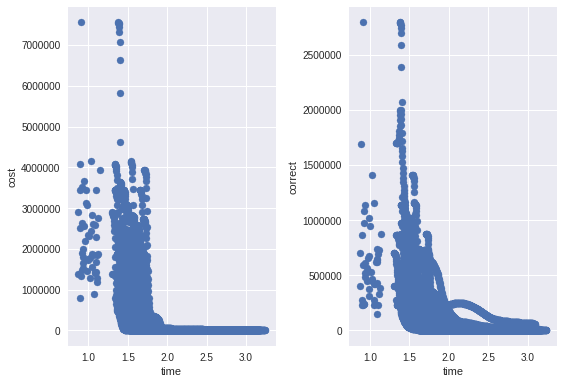

In [24]:
matcompl_grad(10, 10, 3, 0.2, 0.0001, 500)

In [0]:
def matcompl_sgd(rows, cols, rank, percent_missing, lr, steps):
  batch_size = 10
  
  
  config = tf.ConfigProto(allow_soft_placement = True)
  config.gpu_options.allow_growth = True
  
  cost_hist = pd.DataFrame({'cost':[],'time':[],'acc':[]})
  for i in range(50):
    print(i)
    temp_H, temp_W, B_orig, np_mask = gen_matrix(rows, cols, rank, percent_missing)



    with tf.device('/gpu:0'):
      B = tf.constant(B_orig.values)

      pl_mask = tf.placeholder(tf.bool, shape=(rows, cols))

      H =  tf.Variable(temp_H)
      W = tf.Variable(temp_W)
      WH = tf.matmul(W, H)

      cost = tf.reduce_sum(tf.pow(tf.boolean_mask(B, pl_mask) - tf.boolean_mask(WH, pl_mask), 2))
      accuracy = tf.reduce_sum(tf.pow(tf.boolean_mask(B, tf.logical_not(pl_mask)) - tf.boolean_mask(WH, tf.logical_not(pl_mask)), 2))

      train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
      init = tf.global_variables_initializer()




    with tf.Session(config=config) as sess:
        sess.run(init)
        start_time = time.time()
        for i in range(steps):

            sample_mask = np.zeros((rows, cols)).astype(bool)
            sample_mask.ravel()[np.random.choice(np_mask.size, batch_size, replace=False)] = True
            sample_mask = sample_mask & np_mask

            sess.run(train_step, feed_dict={pl_mask:sample_mask.values})
            new_entry = pd.DataFrame({'cost':[sess.run(cost, feed_dict={pl_mask:sample_mask.values})],'time':[time.time() - start_time],'acc':[sess.run(accuracy, feed_dict={pl_mask:sample_mask.values})]})
            cost_hist = cost_hist.append(new_entry,ignore_index=True)


  plt.subplot(1, 2, 1)
  plt.scatter(cost_hist['time'],cost_hist['cost'])
  plt.xlabel("time")
  plt.ylabel("cost")
  
  plt.subplot(1, 2, 2)
  plt.scatter(cost_hist['time'],cost_hist['acc'])
  plt.xlabel("time")
  plt.ylabel("correct")
  
  plt.tight_layout()
  plt.show()
      


In [0]:
matcompl_sgd(10, 10, 3, 0.2, 0.0001, 500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
